#### Data loading and visualization

In [12]:
#imports
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
from PIL import Image
import numpy as np
import warnings

In [13]:
#warnings, nope
warnings.filterwarnings("ignore", category=FutureWarning)


 First 5 rows of train.csv:
                                         file_name  label
0  train_data/a6dcb93f596a43249135678dfcfc17ea.jpg      1
1  train_data/041be3153810433ab146bc97d5af505c.jpg      0
2  train_data/615df26ce9494e5db2f70e57ce7a3a4f.jpg      1
3  train_data/8542fe161d9147be8e835e50c0de39cd.jpg      0
4  train_data/5d81fa12bc3b4cea8c94a6700a477cf2.jpg      1


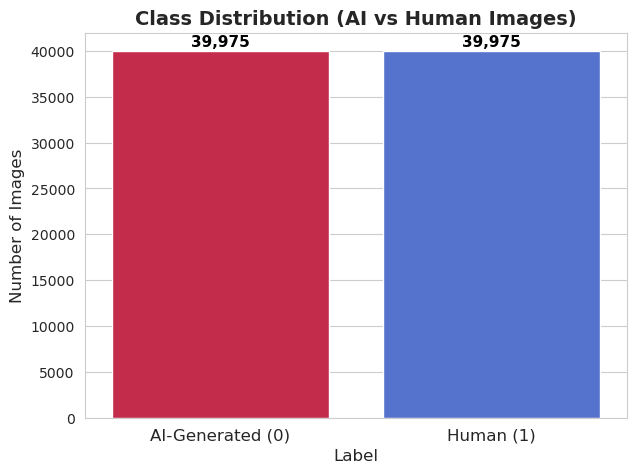

In [14]:
# Define dataset paths
DATASET_DIR = "/home/vsolomon3/AML-project/AHGI/train_data"  # Update with actual path
CSV_FILE = "/home/vsolomon3/AML-project/AHGI/train.csv"

# Load CSV file
df = pd.read_csv(CSV_FILE, index_col=0)

# Rename columns correctly
df.columns = ["file_name", "label"]

# Print the first few rows of train.csv
print("\n First 5 rows of train.csv:")
print(df.head())

# Extract only the filename (remove "train_data/" prefix)
df["file_name"] = df["file_name"].apply(lambda x: os.path.basename(x))

# Construct full image path
df["full_path"] = df["file_name"].apply(lambda x: os.path.join(DATASET_DIR, x))

# Convert label column to integer
df["label"] = df["label"].astype(int)

#  1. Display Class Distribution (Corrected Labels)
label_counts = df["label"].value_counts()
plt.figure(figsize=(7, 5))
sns.set_style("whitegrid")

ax = sns.barplot(x=label_counts.index, y=label_counts.values, palette=["crimson", "royalblue"])
plt.xticks(ticks=[0, 1], labels=["AI-Generated (0)", "Human (1)"], fontsize=12)
plt.ylabel("Number of Images", fontsize=12)
plt.xlabel("Label", fontsize=12)
plt.title("Class Distribution (AI vs Human Images)", fontsize=14, fontweight="bold")

# Add text labels on bars
for i, count in enumerate(label_counts.values):
    ax.text(i, count + 500, f"{count:,}", ha='center', fontsize=11, fontweight="bold", color="black")

plt.show()


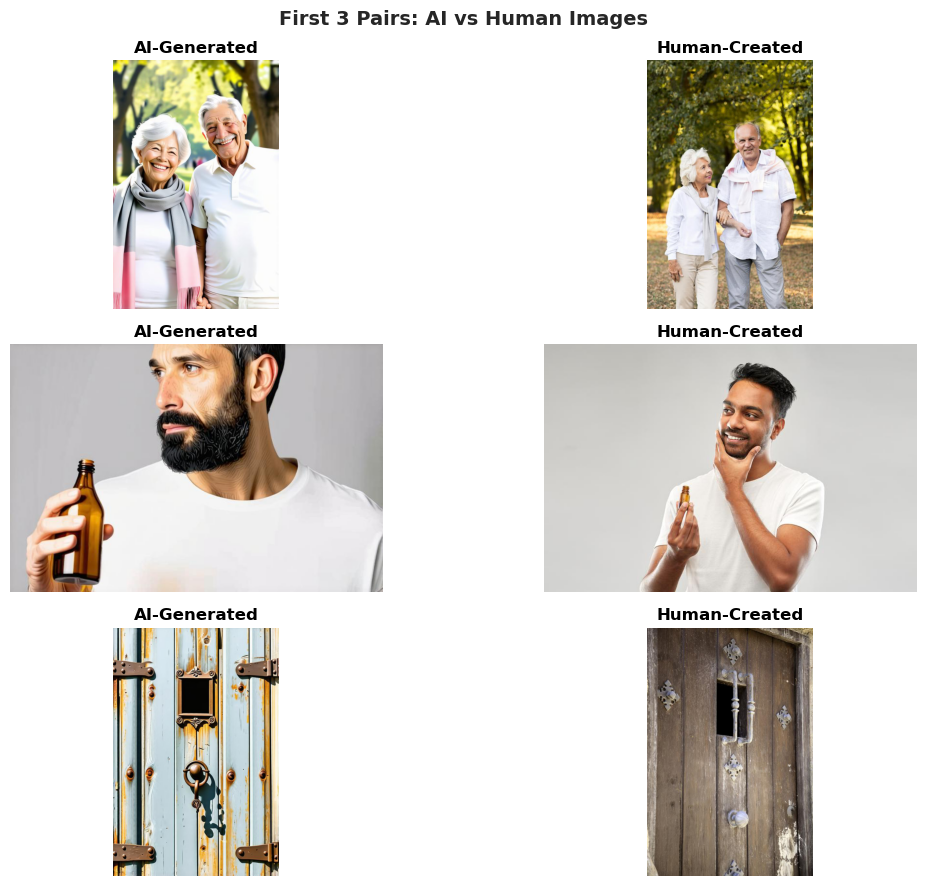

In [15]:
# Display First 6 Images (Side-by-Side in Pairs)
def show_paired_images():
    """
    Displays the first 3 pairs of images: each AI-generated image placed next to its corresponding human-created image.
    """
    fig, axes = plt.subplots(3, 2, figsize=(12, 9))  # 3 rows, 2 columns

    first_six = df.iloc[:6]  # Get first 6 images (ensures alternating AI-Human pairs)
    
    for i in range(3):  # Iterate over 3 pairs
        ai_img_path = first_six.iloc[i * 2]["full_path"]  # AI image (Label 0)
        human_img_path = first_six.iloc[i * 2 + 1]["full_path"]  # Human image (Label 1)

        # Load and display images
        ai_img = Image.open(ai_img_path)
        human_img = Image.open(human_img_path)

        # AI-generated image (Left)
        axes[i, 0].imshow(ai_img)
        axes[i, 0].axis("off")
        axes[i, 0].set_title("AI-Generated", fontsize=12, fontweight="bold", color="black")

        # Human-created image (Right)
        axes[i, 1].imshow(human_img)
        axes[i, 1].axis("off")
        axes[i, 1].set_title("Human-Created", fontsize=12, fontweight="bold", color="black")

    plt.suptitle("First 3 Pairs: AI vs Human Images", fontsize=14, fontweight="bold")
    plt.tight_layout()
    plt.show()

# Show the first 3 pairs of images
show_paired_images()

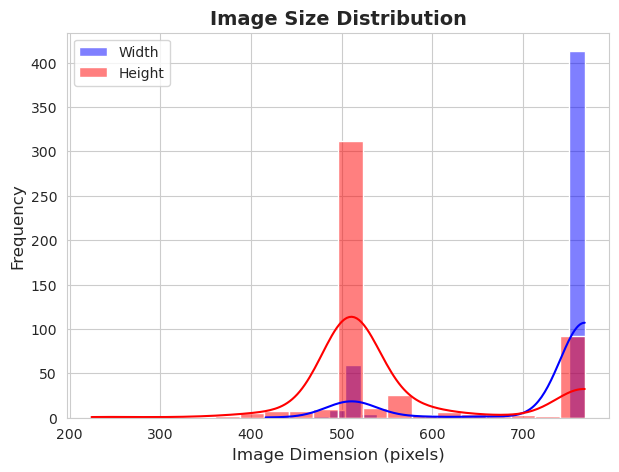

In [16]:
# Image Size Distribution Plot
image_shapes = []
for img_path in df["full_path"].sample(500):  # Sample 500 images for efficiency
    img = Image.open(img_path)
    image_shapes.append(img.size)  # (width, height)

# Convert to DataFrame for visualization
image_sizes_df = pd.DataFrame(image_shapes, columns=["Width", "Height"])

# Plot image size distribution
plt.figure(figsize=(7, 5))
sns.set_style("whitegrid")

sns.histplot(image_sizes_df["Width"], bins=20, color="blue", label="Width", kde=True)
sns.histplot(image_sizes_df["Height"], bins=20, color="red", label="Height", kde=True)

plt.xlabel("Image Dimension (pixels)", fontsize=12)
plt.ylabel("Frequency", fontsize=12)
plt.title("Image Size Distribution", fontsize=14, fontweight="bold")
plt.legend()
plt.show()

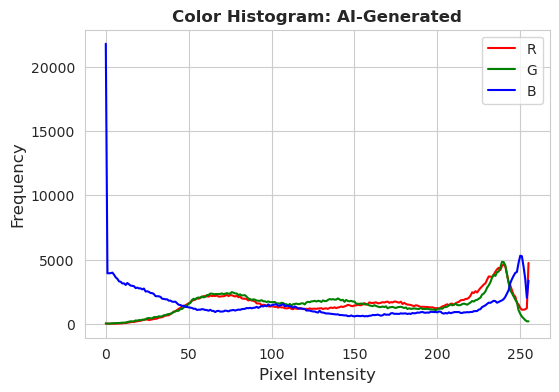

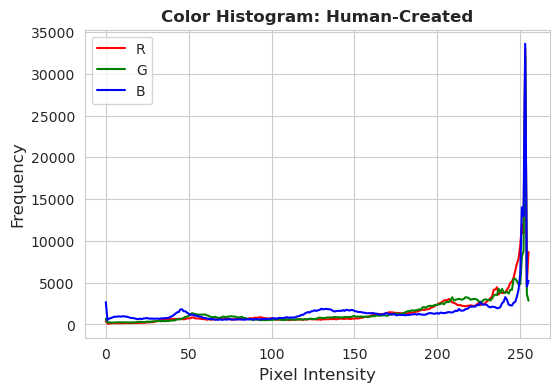

In [17]:
# Color Histogram Visualization
def plot_color_histogram(image_path, title):
    """
    Plots RGB color histogram for a given image.
    """
    img = cv2.imread(image_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    colors = ("r", "g", "b")
    plt.figure(figsize=(6, 4))
    for i, col in enumerate(colors):
        hist = cv2.calcHist([img], [i], None, [256], [0, 256])
        sns.lineplot(x=np.arange(256), y=hist.flatten(), color=col, label=col.upper())

    plt.title(f"Color Histogram: {title}", fontsize=12, fontweight="bold")
    plt.xlabel("Pixel Intensity", fontsize=12)
    plt.ylabel("Frequency", fontsize=12)
    plt.legend()
    plt.show()

# Show color histogram of the first AI-generated image
ai_image_path = df[df["label"] == 0]["full_path"].iloc[0]  # Label 0 = AI
plot_color_histogram(ai_image_path, "AI-Generated")

# Show color histogram of the first Human-created image
human_image_path = df[df["label"] == 1]["full_path"].iloc[0]  # Label 1 = Human
plot_color_histogram(human_image_path, "Human-Created")
